# Autoregressive Image Generation without Vector Quantization

This notebook samples from pre-trained MAR+DiffLoss models, which are class-conditional masked autoregressive models trained on ImageNet to model continuous latent tokens. MAR+DiffLoss achieves state-of-the-art performance on the ImageNet benchmarks. A large portion of this demo is adopted from [DiT](https://github.com/facebookresearch/DiT).

[Paper](https://arxiv.org/abs/2406.11838) | [GitHub](https://github.com/LTH14/mar)

# 1. Setup

We recommend using GPUs (Runtime > Change runtime type > Hardware accelerator > GPU). Run this cell to clone the MAR GitHub repo and setup PyTorch. You only have to run this once.

In [ ]:
import os

# !git clone https://github.com/LTH14/mar.git
# import os
# os.chdir('mar')
os.environ['PYTHONPATH'] = '/opt/disk2/dwang/vton2/mar'
# !pip install timm==0.9.12
# MAR imports:
import torch
import numpy as np
from models import mar
from models.vae import AutoencoderKL
from torchvision.utils import save_image
from util import download
from PIL import Image
from IPython.display import display

torch.set_grad_enabled(False)
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    print("GPU not found. Using CPU instead.")

# Download Pre-trained VAE

In [2]:
download.download_pretrained_vae()

100%|██████████| 254/254 [00:02<00:00, 104.33MB/s]


# 2. Load and download pre-trained MAR models

In [3]:
import os

# !git clone https://github.com/LTH14/mar.git
# import os
# os.chdir('mar')
os.environ['PYTHONPATH'] = '/opt/disk2/dwang/vton2/mar'
# !pip install timm==0.9.12
# MAR imports:
import torch
import numpy as np
from models import mar
from models.vae import AutoencoderKL
from torchvision.utils import save_image
from util import download
from PIL import Image
from IPython.display import display

torch.set_grad_enabled(False)
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    print("GPU not found. Using CPU instead.")

100%|██████████| 7191/7191 [01:12<00:00, 99.31MB/s] 
/tmp/ipykernel_102616/188355288.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("pretrained

Working with z of shape (1, 16, 16, 16) = 4096 dimensions.


/opt/disk2/dwang/vton2/mar/models/vae.py:464: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sd = torch.load(path, map_location="cpu")["model"]


Loading pre-trained KL-VAE
Missing keys:
[]
Unexpected keys:
[]
Restored from pretrained_models/vae/kl16.ckpt


# 3. Sample from Pre-trained MAR Models

You can customize several sampling options. For the full list of ImageNet classes, [check out this](https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/).

  0%|          | 0/64 [00:00<?, ?it/s]

100%|██████████| 64/64 [00:45<00:00,  1.39it/s]


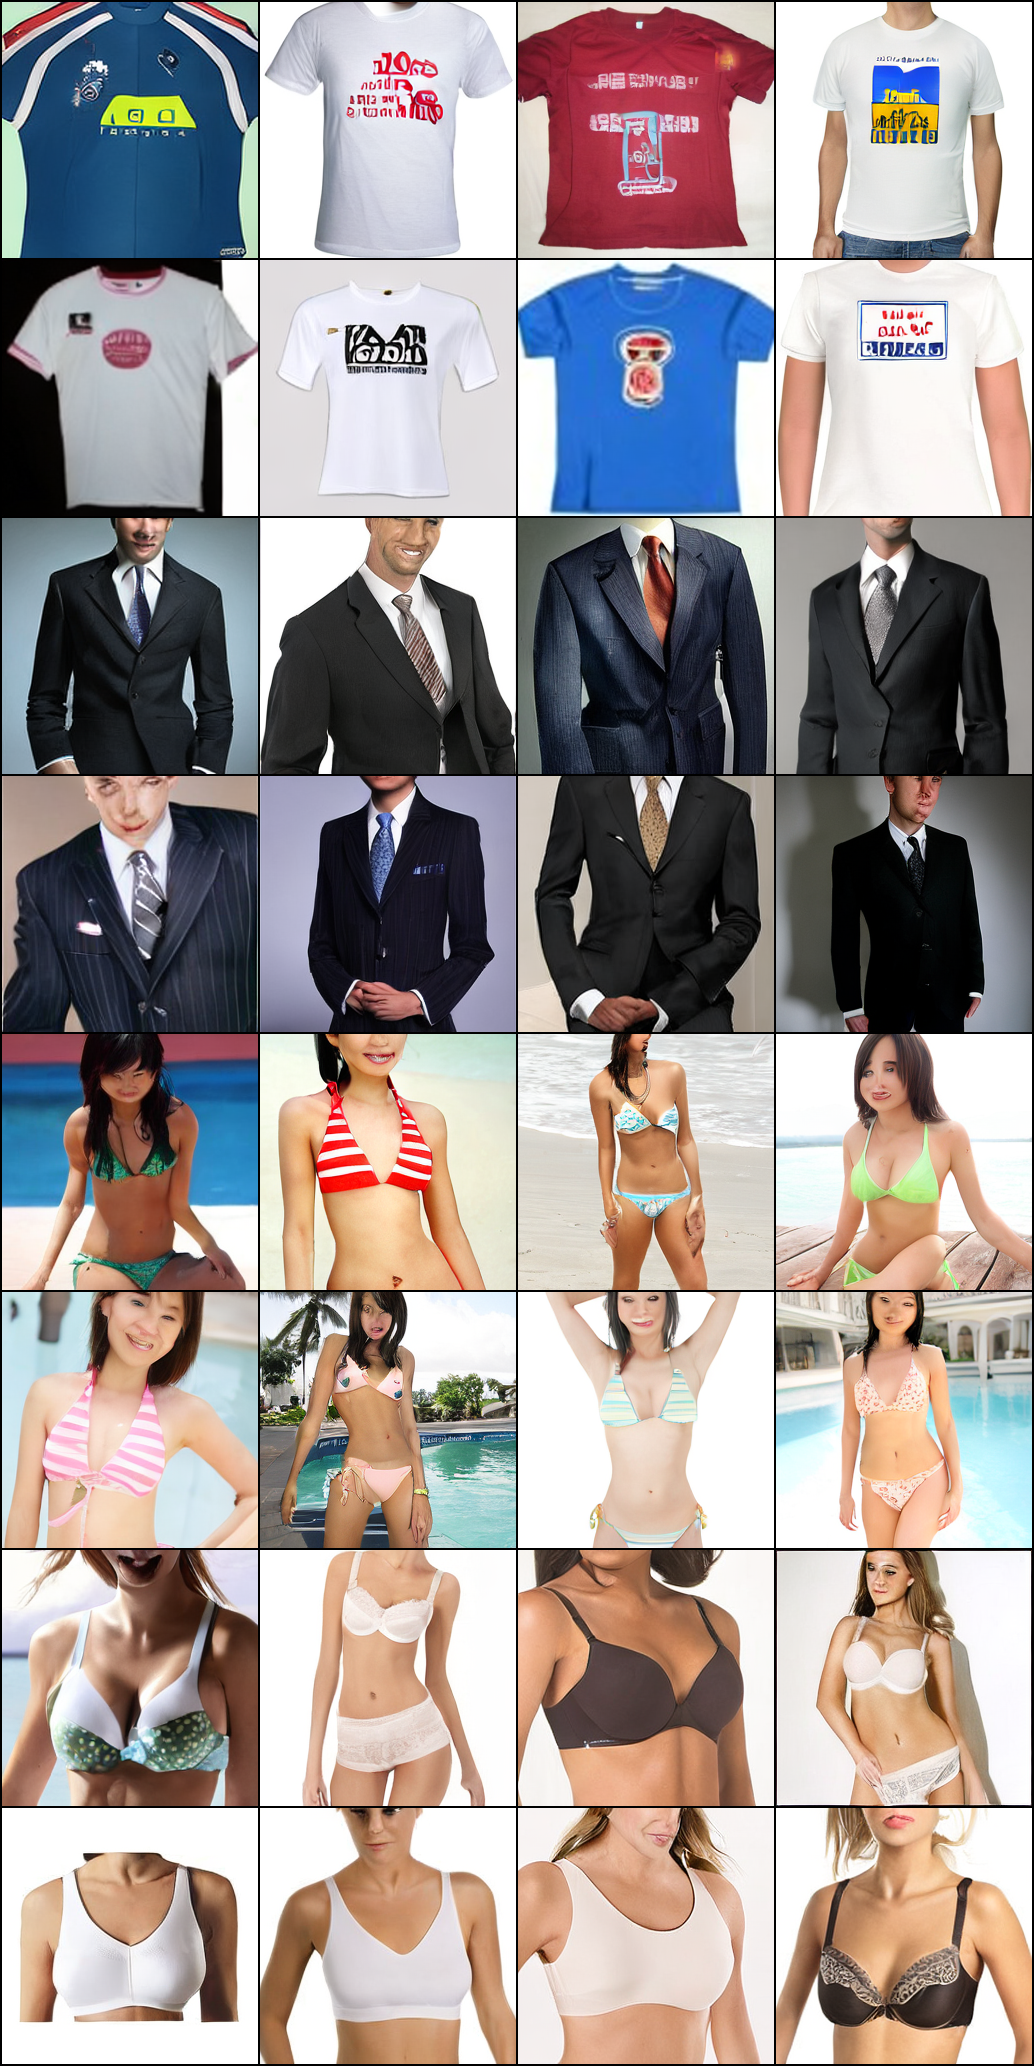

In [8]:
# Set user inputs:
seed = 0  #@param {type:"number"}
torch.manual_seed(seed)
np.random.seed(seed)
num_ar_steps = 64  #@param {type:"slider", min:1, max:256, step:1}
cfg_scale = 4  #@param {type:"slider", min:1, max:10, step:0.1}
cfg_schedule = "constant"  #@param ["linear", "constant"]
temperature = 1.0  #@param {type:"slider", min:0.9, max:1.1, step:0.01}
class_labels = 610,  610,  610,  610,610,  610,  610,  610, 834, 834, 834,834,834, 834, 834,834, 445, 445, 445,445,  445, 445, 445,445, 459, 459, 459, 459, 459, 459, 459, 459  #@param {type:"raw"}
samples_per_row = 4  #@param {type:"number"}

with torch.amp.autocast('cuda'):
    sampled_tokens = model.sample_tokens(bsz=len(class_labels),
                                         num_iter=num_ar_steps,
                                         cfg=cfg_scale,
                                         cfg_schedule=cfg_schedule,
                                         labels=torch.Tensor(class_labels).long().cuda(),
                                         temperature=temperature,
                                         progress=True)
    sampled_images = vae.decode(sampled_tokens / 0.2325)

# Save and display images:
save_image(sampled_images, "sample.png", nrow=int(samples_per_row), normalize=True, value_range=(-1, 1))
samples = Image.open("sample.png")
display(samples)